In [478]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, PredefinedSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import scipy.stats as st
import calendar
import os
import missingno as msno
import datetime as dt
import time
import shap
from pymer4.models import Lmer
from xgboost import XGBRegressor, plot_importance
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def assign_cycle_vars(df, suffix, var_pos, var_cycle_length):
    df['sin_term_'+suffix] = np.sin(df[var_pos]/df[var_cycle_length])
    df['cos_term_'+suffix] = np.cos(df[var_pos]/df[var_cycle_length])
    return None
def days_between(d1, d2):
    d1 = dt.datetime.strptime(d1, "%Y-%m-%d")
    d2 = dt.datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days+1
def logify(x):
    return np.log(x - np.min(x) + 1)
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key',suffixes=['','']).drop('key', 1))
def df_subset(df,sku_num, sale_type):
    return df[[x==sku_num and y==sale_type for x,y in zip(df['sku_num'],df['sale_type'])]]
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

# univariate outlier detection, based on MAD (source: shorturl.at/mpuFO)
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points)
    diff = points - median
    abs_deviation = np.abs(diff)
    med_abs_deviation = np.median(abs_deviation)
    modified_z_score = 0.6745 * diff / med_abs_deviation

    return np.abs(modified_z_score) > thresh

def get_coef(features,mod):
    out = pd.DataFrame(zip(features,mod.coef_),columns=['feature','coef']).sort_values('coef',ascending=False)
    return out



In [4]:
main_dir = Path('/Users/zach/Documents/git/thrasio')
data_dir = main_dir / 'Case_Study_Materials'
file_path = data_dir / 'CASE_STUDY_FINAL.csv'

In [5]:
dat_orig = pd.read_csv(file_path, low_memory=False)

In [6]:
dat_orig.shape

(266500, 7)

In [7]:
dat_init = dat_orig.copy()

In [8]:
dat_init['datetime'] = pd.to_datetime(dat_init['Date'])
dat_init['sku_brand'] = [x+'-'+str(y) for x,y in zip(dat_init['SKU_mkt'],dat_init['Brand_ID'])]

Create dimension tables for sku and date

In [9]:
dim_sku = pd.DataFrame(dat_init['sku_brand'].unique(),columns=['sku_brand'])

In [10]:
dim_sku['sku_num'] = list(range(dim_sku.shape[0]))

In [11]:
dim_sku['Brand_ID'] = [int(s.split('-')[-1]) for s in dim_sku['sku_brand']]

In [12]:
dim_date = pd.DataFrame(dat_init['datetime'].unique(),columns=['datetime'])

In [13]:
dim_date['date'] = dim_date['datetime'].dt.date
dim_date['year'] = dim_date['datetime'].dt.year
dim_date['month'] = dim_date['datetime'].dt.month
dim_date['dayofyear'] = dim_date['datetime'].dt.dayofyear
dim_date['dayofmonth'] = dim_date['datetime'].dt.day
dim_date['dayofweek'] = dim_date['datetime'].dt.weekday
dim_date['days_in_month'] = [calendar.monthrange(y,m)[1] for y,m in zip(dim_date['year'], dim_date['month'])]
dim_date['days_in_year'] = [366 if calendar.isleap(y) else 365 for y in dim_date['year']]
dim_date['days_in_week'] = 7
dim_date['year_month'] = [str(y)+'-'+str(m) if m > 9 else str(y)+'-0'+str(m) for y,m in zip(dim_date['year'], dim_date['month'])]
assign_cycle_vars(dim_date, 'fracofyear', 'dayofyear', 'days_in_year')
assign_cycle_vars(dim_date, 'fracofmonth', 'dayofmonth', 'days_in_month')
assign_cycle_vars(dim_date, 'fracofweek', 'dayofweek', 'days_in_week')

In [14]:
dim_date['day_ordinal'] = dim_date['datetime'].rank(method='dense')
dim_date['month_ordinal'] = dim_date['year_month'].rank(method='dense')
#TODO add weekenddates, monthenddate, yearenddate

In [15]:
# "previous" dates
dim_date['date_prior_day'] = dim_date['date'] - dt.timedelta(days=1)
dim_date['date_prior_week'] = dim_date['date'] - dt.timedelta(days=7)
dim_date['date_prior_year'] = dim_date['date'] - dt.timedelta(weeks=52)

Create skeleton

In [16]:
skel = cartesian_product_basic(dim_sku,dim_date)

Add dim table data to main dataset

In [17]:
dat = skel.merge(dat_init, how='left', on=['sku_brand','Brand_ID','datetime'],suffixes=['',''])

In [18]:
dat['missing'] = (dat['Total_Units'].isna())*1

Inspect missingness

In [19]:
df_missing = dat[['sku_num','missing','day_ordinal']].copy()
df_missing_agg = df_missing.groupby('sku_num')['missing'].mean().reset_index(drop=False)
df_missing.sort_values(['day_ordinal','sku_num'])
df_missing_pivot = df_missing.pivot(index='sku_num',columns='day_ordinal',values='missing').reset_index(drop=False)
df_missing_pivot = df_missing_pivot.merge(df_missing_agg, how='left', on='sku_num')
df_missing_pivot.sort_values('missing', ascending=False,inplace=True)

In [20]:
df_missing_pivot.rename(columns={'missing':'total_sku_pct_missing'},inplace=True)

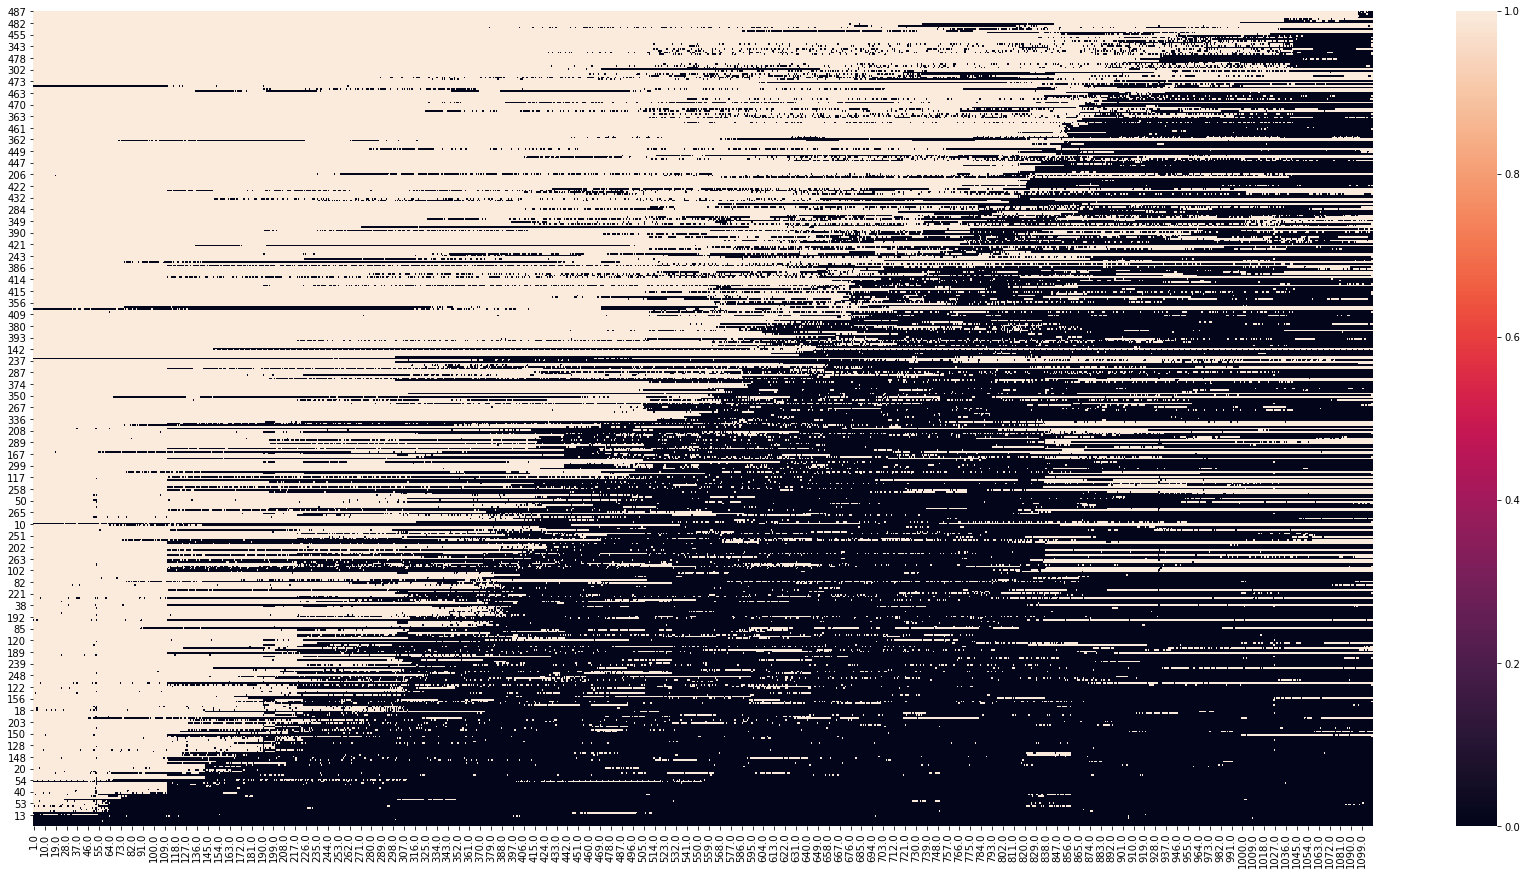

In [21]:
plt.figure(figsize=(30,15))
sns.heatmap(df_missing_pivot.drop(labels=['total_sku_pct_missing', 'sku_num'],axis=1))

Inspect sample size for each sku

In [22]:
# group by sku_num, sku_mkt, month: get % missing for each month and use as predictor
def day_of_min_nonmissing(df):
    return df.loc[df['missing'].idxmin(),'day_ordinal']

min_nonmissing_days = pd.DataFrame(dat.groupby('sku_num').apply(lambda x:day_of_min_nonmissing(x)),columns=['min_nonmissing_day']).reset_index(drop=False)
dat = dat.merge(min_nonmissing_days, how='left', on='sku_num',suffixes=['',''])


Limit data for each SKU to after first non-missing day

In [23]:
dat = dat[[True if x >= y else False for x,y in zip(dat['day_ordinal'],dat['min_nonmissing_day'])]]
dat['missing'] = dat['missing'].astype('float64')
dat.fillna(int(0),inplace=True,downcast=False)

Aggregate data by SKU and month (and brand and month)

In [24]:
dat_mod = pd.DataFrame(dat.groupby(['sku_num', 'sku_brand','Brand_ID', 'days_in_month',
             'year_month','year','month','month_ordinal']).agg(
    PPC_Units=pd.NamedAgg('PPC_Units',np.sum),
    Organic_Units=pd.NamedAgg('Organic_Units',np.sum),
    PPC_Cost=pd.NamedAgg('PPC_Cost',np.sum),
    days_missing=pd.NamedAgg('missing',np.sum) 
)).reset_index(drop=False)

In [25]:
dat_mod_brand = dat.groupby(['Brand_ID','month_ordinal','days_in_month', 'year_month','year','month']).agg(
    PPC_Units=pd.NamedAgg('PPC_Units',np.sum),
    Organic_Units=pd.NamedAgg('Organic_Units',np.sum),
    PPC_Cost=pd.NamedAgg('PPC_Cost',np.sum),
    days_missing=pd.NamedAgg('missing',np.sum),
    sku_count=pd.NamedAgg('sku_num','nunique')
).reset_index(drop=False)

Generate PPC Cost variable

In [26]:
dat_mod['PPC_Cost_per_unit'] = abs(dat_mod['PPC_Cost']) / (dat_mod['PPC_Units']+1)
dat_mod_brand['brand_PPC_Cost_per_unit'] = abs(dat_mod_brand['PPC_Cost']) / (dat_mod_brand['PPC_Units']+1)

In [27]:
min_month_ordinals = pd.DataFrame(dat_mod.groupby('sku_num')['month_ordinal'].min()).reset_index()
min_month_ordinals.rename(columns={'month_ordinal':'min_month_ordinal'},inplace=True)
dat_mod = dat_mod.merge(min_month_ordinals, how='left', on='sku_num',suffixes=['',''])

In [28]:
dat_mod['pct_missing'] = dat_mod['days_missing'] / dat_mod['days_in_month']
dat_mod_brand['brand_pct_missing'] = dat_mod_brand['days_missing'] / (dat_mod_brand['days_in_month']*dat_mod_brand['sku_count'])

In [29]:
value_vars=['PPC_Units','Organic_Units']
dat_mod = dat_mod.melt(id_vars=set(dat_mod.columns)-set(value_vars),value_vars=value_vars,var_name='sale_type',value_name='Units')
dat_mod_brand = dat_mod_brand.melt(id_vars=set(dat_mod_brand.columns)-set(value_vars),value_vars=value_vars,var_name='sale_type',value_name='brand_Units')


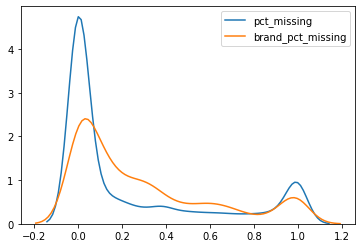

In [30]:
sns.kdeplot(dat_mod['pct_missing'])
sns.kdeplot(dat_mod_brand['brand_pct_missing'])

In [31]:
#TODO correlations between PPC cost and PPC units/organic units
dat_mod.duplicated(subset=['sku_num','year_month','sale_type']).sum()

0

In [32]:
def assign_missingness_group(x):
    if x > 0.7:
        return 'HIGH'
    elif x > 0.3:
        return 'MED'
    else:
        return 'LOW'
    
df_missing_pivot['sku_missingness_group'] = [assign_missingness_group(x) for x in df_missing_pivot['total_sku_pct_missing']]



In [33]:
# create groups of low, medium, and high-missingness products
dat_mod = dat_mod.merge(df_missing_pivot[['sku_num', 'total_sku_pct_missing','sku_missingness_group']], how='left',on='sku_num')


In [34]:
dat_mod = dat_mod.merge(dat_mod_brand[['sale_type','Brand_ID','year_month','brand_pct_missing','brand_PPC_Cost_per_unit', 'brand_Units']],how='left',on=['sale_type','Brand_ID','year_month'])


In [36]:
dat_mod['log_Units'] = logify(dat_mod['Units'])
dat_mod['PPC_Cost'] = abs(dat_mod['PPC_Cost'])
dat_mod['log_PPC_Cost'] = logify(dat_mod['PPC_Cost'])
dat_mod['log_PPC_Cost_per_unit'] = logify(dat_mod['PPC_Cost_per_unit'])
dat_mod['log_brand_Units'] = logify(dat_mod['brand_Units'])
dat_mod['log_brand_PPC_Cost_per_unit'] = logify(dat_mod['brand_PPC_Cost_per_unit'])
dat_mod['months_in_year'] = 12
dat_mod['sale_type_PPC'] = [1 if s == 'PPC_Units' else 0 for s in dat_mod['sale_type']]
dat_mod['log_PPC_Cost_per_unit_PPCONLY'] = dat_mod['log_PPC_Cost_per_unit'] * dat_mod['sale_type_PPC']
assign_cycle_vars(dat_mod, 'fracofyear', 'month', 'months_in_year')


In [37]:
# remove months that have 100% missing
dat_mod = dat_mod[dat_mod['pct_missing'] < 1.0]

In [38]:
df_subset(dat_mod,114,'PPC_Units').shape

(21, 30)

In [39]:
dat_mod.sort_values(['sale_type','Brand_ID','sku_num','month_ordinal'],inplace=True)
#dat_mod

In [40]:
dat_mod['month_ordinal_prior'] = dat_mod['month_ordinal'] - 1
dat_mod['month_ordinal_prior_2'] = dat_mod['month_ordinal'] - 2

In [41]:
# eliminate the first month
dat_mod = dat_mod[[True if x > y or x == 37 else False for x,y in zip(dat_mod['month_ordinal'],dat_mod['min_month_ordinal'])]]


In [42]:
#dat_sub = dat_mod[[True if b==3 and st=='Organic_Units' else False for b,st in zip(dat_mod['Brand_ID'],dat_mod['sale_type'])]].sort_values(['sku_num','month_ordinal'])
#sns.lineplot(x='month_ordinal',y='log_Units',hue='sku_num',data=dat_sub)

In [43]:
dat_mod = dat_mod.merge(dat_mod[['sku_num','sale_type','month_ordinal','Units','log_Units','brand_Units','log_brand_Units','pct_missing','brand_pct_missing']], how='left',
                      left_on=('sku_num','sale_type','month_ordinal_prior'),
                        right_on=('sku_num','sale_type','month_ordinal'), suffixes=['','_prior_month'])

dat_mod = dat_mod.merge(dat_mod[['sku_num','sale_type','month_ordinal','Units','log_Units','brand_Units','log_brand_Units','pct_missing','brand_pct_missing']], how='left',
                      left_on=('sku_num','sale_type','month_ordinal_prior_2'),
                        right_on=('sku_num','sale_type','month_ordinal'), suffixes=['','_prior_2_month'])

In [44]:
dat_mod.sort_values(['sale_type','sku_num','year_month'],inplace=True)

In [45]:
dat_mod['Units_last_valid'] = dat_mod.groupby(['sku_num','sale_type'])['Units_prior_month'].transform(
    lambda grp: grp.fillna(method='pad')
)
dat_mod['log_Units_last_valid'] = dat_mod.groupby(['sku_num','sale_type'])['log_Units_prior_month'].transform(
    lambda grp: grp.fillna(method='pad')
)
dat_mod['pct_missing_last_valid'] = dat_mod.groupby(['sku_num','sale_type'])['pct_missing_prior_month'].transform(
    lambda grp: grp.fillna(method='pad')
)
dat_mod['brand_Units_last_valid'] = dat_mod.groupby(['sku_num','sale_type'])['brand_Units_prior_month'].transform(
    lambda grp: grp.fillna(method='pad')
)
dat_mod['log_brand_Units_last_valid'] = dat_mod.groupby(['sku_num','sale_type'])['log_brand_Units_prior_month'].transform(
    lambda grp: grp.fillna(method='pad')
)
dat_mod['brand_pct_missing_last_valid'] = dat_mod.groupby(['sku_num','sale_type'])['brand_pct_missing_prior_month'].transform(
    lambda grp: grp.fillna(method='pad')
)

In [46]:
dat_mod['log_Units_prior_trend'] = dat_mod['log_Units_prior_month'] - dat_mod['log_Units_prior_2_month']

In [47]:
# naive model "feature"
dat_groupby_saletype_month = dat_mod.groupby(['sale_type','year_month']).agg(
    monthly_saletype_avg_Units=pd.NamedAgg('Units',np.mean)
).reset_index(drop=False)
dat_mod = dat_mod.merge(dat_groupby_saletype_month, on=['sale_type','year_month'],how='left')

In [48]:
dat_mod = dat_mod.merge(dat_mod[['sale_type','sku_num', 'month_ordinal','monthly_saletype_avg_Units']],
              left_on=['sale_type','sku_num','month_ordinal_prior'],
              right_on=['sale_type','sku_num','month_ordinal'],how='left',
              suffixes=['','_prior_month'])

In [49]:
dat_mod.sort_values(['sale_type','sku_num','month_ordinal'])
dat_mod['monthly_saletype_avg_Units_last_valid'] = dat_mod.groupby(['sale_type'])['monthly_saletype_avg_Units_prior_month'].transform(
    lambda grp: grp.fillna(method='pad')
)

In [50]:
dat_mod['log_monthly_saletype_avg_Units_prior_month'] = logify(dat_mod['monthly_saletype_avg_Units_prior_month'])
dat_mod['log_monthly_saletype_avg_Units_last_valid'] = logify(dat_mod['monthly_saletype_avg_Units_last_valid'])

In [51]:
potential_na_features = [
    'log_Units_prior_month',
    'log_Units_prior_2_month',
    'log_Units_last_valid',
    'log_brand_Units_prior_month',
    'log_brand_Units_last_valid',
    'pct_missing_prior_month',
    'pct_missing_last_valid',
    'brand_pct_missing_prior_month',
    'brand_pct_missing_last_valid',
    'log_monthly_saletype_avg_Units_prior_month',
    'log_monthly_saletype_avg_Units_last_valid',
    'log_Units_prior_month_weighted',
    'log_brand_Units_prior_month_weighted',
    'log_Units_prior_trend'
]

In [52]:
dat_mod['log_Units_prior_month_weighted'] = dat_mod['log_Units_prior_month'] * (1-dat_mod['pct_missing_prior_month'])
dat_mod['log_brand_Units_prior_month_weighted']=dat_mod['log_brand_Units_prior_month'] * (1-dat_mod['brand_pct_missing_prior_month'])

In [53]:
for col in potential_na_features:
    newcol = col+'_MISSING'
    dat_mod[newcol] = (dat_mod[col].isna())*1

In [54]:
dat_trainvalid = dat_mod[dat_mod['month_ordinal'] <= 31].copy()
dat_train = dat_trainvalid[dat_trainvalid['month_ordinal'] <= 23].copy()

In [55]:
# order training data by month
dat_train.sort_values(['month_ordinal','sku_num','sale_type'],inplace=True)

In [56]:
medians_potential_na_features = dat_train[potential_na_features].apply(lambda x: np.nanmedian(x))

In [57]:
dat_test = dat_mod[dat_mod['month_ordinal'] > 31].copy()
dat_valid = dat_trainvalid[dat_trainvalid['month_ordinal'] > 23].copy()

In [58]:
for col in potential_na_features:
    dat_train[col] = dat_train[col].fillna(value=medians_potential_na_features[col])
    dat_valid[col] = dat_valid[col].fillna(value=medians_potential_na_features[col])
    dat_test[col] = dat_test[col].fillna(value=medians_potential_na_features[col])

In [59]:
target = ['log_Units']
target_min = np.min(dat_mod['Units'])

In [488]:
def get_scores(df):
    total_scores = score_dict(df)
    grouped_scores = dict(df.groupby('sku_missingness_group').apply(lambda df_grp: score_dict(df_grp)))
    saletype_scores = dict(df.groupby('sale_type').apply(lambda df_grp: score_dict(df_grp)))

    return {'total_scores':total_scores, 'grouped_scores':grouped_scores, 'saletype_scores':saletype_scores}

def score_dict(df):
    R2 = np.round(r2_score(df[target],df['pred']),3)
    RMSE = np.round(rmse(df[target],df['pred']),3)
    R2_raw = np.round(r2_score(np.exp(df[target])+target_min-1,np.exp(df['pred'])+target_min-1))
    RMSE_raw = np.round(rmse(np.exp(df[target])+target_min-1,np.exp(df['pred'])+target_min-1))
    return {'r2':R2, 'rmse':RMSE, 'r2_raw':R2_raw, 'rmse_raw':RMSE_raw}

def score_model():
    train_scores = get_scores(dat_train)
    valid_scores = get_scores(dat_valid)
    test_scores = get_scores(dat_test)
    return {'train':train_scores, 'valid':valid_scores, 'test':test_scores}


In [489]:
model_dict={   }
# model name -> train/valid/test scores -> valid/test score breakdown by missingness group

In [490]:
# naive model
naive_feature = 'log_monthly_saletype_avg_Units_last_valid'
dat_train['pred'] = dat_train[naive_feature]
dat_valid['pred'] = dat_valid[naive_feature]
dat_test['pred'] = dat_test[naive_feature]

In [491]:
model_dict['naive'] = score_model()

In [492]:

features_mod1 = [naive_feature]
mod1 = ElasticNet(random_state=1)
mod1.fit(X=dat_train[features_mod1],y=dat_train[target])

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

In [493]:
dat_train['pred'] = mod1.predict(dat_train[features_mod1])
dat_valid['pred'] = mod1.predict(dat_valid[features_mod1])
dat_test['pred'] = mod1.predict(dat_test[features_mod1])
model_dict['mod1'] = score_model()

In [494]:
features_mod2 = ['log_monthly_saletype_avg_Units_last_valid', 'log_Units_last_valid']
mod2 = ElasticNet(random_state=1)
mod2.fit(X=dat_train[features_mod2],y=dat_train[target])

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

In [495]:
dat_train['pred'] = mod2.predict(dat_train[features_mod2])
dat_valid['pred'] = mod2.predict(dat_valid[features_mod2])
dat_test['pred'] = mod2.predict(dat_test[features_mod2])
model_dict['mod2'] = score_model()

In [496]:
tss = TimeSeriesSplit(n_splits=5)
features_mod3 = features_mod2
mod3 = ElasticNetCV(random_state=1,cv=tss)
mod3.fit(X=dat_train[features_mod3],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [497]:
dat_train['pred'] = mod3.predict(dat_train[features_mod3])
dat_valid['pred'] = mod3.predict(dat_valid[features_mod3])
dat_test['pred'] = mod3.predict(dat_test[features_mod3])
model_dict['mod3'] = score_model()

In [498]:
# add prior month units and pct missing prior month
features_mod4 = ['log_monthly_saletype_avg_Units_last_valid', 'log_Units_last_valid', 
                 'log_Units_prior_month','pct_missing_prior_month']
mod4 = ElasticNetCV(random_state=1,cv=tss)
mod4.fit(X=dat_train[features_mod4],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [499]:
dat_train['pred'] = mod4.predict(dat_train[features_mod4])
dat_valid['pred'] = mod4.predict(dat_valid[features_mod4])
dat_test['pred'] = mod4.predict(dat_test[features_mod4])
model_dict['mod4'] = score_model()

In [500]:
# add prior month MISSING variables
features_mod5 = ['log_monthly_saletype_avg_Units_last_valid', 'log_Units_last_valid', 
                 'log_Units_prior_month','pct_missing_prior_month',
                 'log_Units_prior_month_MISSING'
                ]
mod5 = ElasticNetCV(random_state=1,cv=tss)
mod5.fit(X=dat_train[features_mod5],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [501]:
dat_train['pred'] = mod5.predict(dat_train[features_mod5])
dat_valid['pred'] = mod5.predict(dat_valid[features_mod5])
dat_test['pred'] = mod5.predict(dat_test[features_mod5])
model_dict['mod5'] = score_model()

In [502]:
# add cyclical variables and trend variable
features_mod6 = ['log_monthly_saletype_avg_Units_last_valid',
                 'log_Units_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal']
mod6 = ElasticNetCV(random_state=1,cv=tss)
mod6.fit(X=dat_train[features_mod6],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [503]:
dat_train['pred'] = mod6.predict(dat_train[features_mod6])
dat_valid['pred'] = mod6.predict(dat_valid[features_mod6])
dat_test['pred'] = mod6.predict(dat_test[features_mod6])
model_dict['mod6'] = score_model()

In [504]:
# add PPC_cost per unit
features_mod7 = ['log_monthly_saletype_avg_Units_last_valid',
                 'log_Units_prior_month',
                 'pct_missing_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal',
                 'log_PPC_Cost_per_unit_PPCONLY',
                 'sale_type_PPC'
                ]
mod7 = ElasticNetCV(random_state=1,cv=tss)
mod7.fit(X=dat_train[features_mod7],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [505]:
dat_train['pred'] = mod7.predict(dat_train[features_mod7])
dat_valid['pred'] = mod7.predict(dat_valid[features_mod7])
dat_test['pred'] = mod7.predict(dat_test[features_mod7])
model_dict['mod7'] = score_model()

In [506]:
# substitute log_Units_prior_month_weighted by lack of missingness
features_mod8 = ['log_monthly_saletype_avg_Units_last_valid',
                 #'log_Units_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal',
                 'log_PPC_Cost_per_unit_PPCONLY',
                 'sale_type_PPC',
                 'log_Units_prior_month_weighted'
                ]
mod8 = ElasticNetCV(random_state=1,cv=tss)
mod8.fit(X=dat_train[features_mod8],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [507]:
dat_train['pred'] = mod8.predict(dat_train[features_mod8])
dat_valid['pred'] = mod8.predict(dat_valid[features_mod8])
dat_test['pred'] = mod8.predict(dat_test[features_mod8])
model_dict['mod8'] = score_model()

In [508]:
# add brand units prior month: not very effective
features_mod9 = ['log_monthly_saletype_avg_Units_last_valid',
                 'log_Units_prior_month',
                 'pct_missing_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal',
                 'log_PPC_Cost_per_unit_PPCONLY',
                 'sale_type_PPC',
                 'log_brand_Units_prior_month'
                ]
mod9 = ElasticNetCV(random_state=1,cv=tss)
mod9.fit(X=dat_train[features_mod9],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [509]:
dat_train['pred'] = mod9.predict(dat_train[features_mod9])
dat_valid['pred'] = mod9.predict(dat_valid[features_mod9])
dat_test['pred'] = mod9.predict(dat_test[features_mod9])
model_dict['mod9'] = score_model()

In [510]:
# add brand units prior month: not very effective
features_mod10 = ['log_monthly_saletype_avg_Units_last_valid',
                 'log_Units_prior_month',
                 'pct_missing_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal',
                 'log_PPC_Cost_per_unit_PPCONLY',
                 'sale_type_PPC',
                 'log_brand_Units_prior_month',
                  'log_Units_prior_2_month'
                ]
mod10 = ElasticNetCV(random_state=1,cv=tss)
mod10.fit(X=dat_train[features_mod10],y=dat_train[target].values.ravel())

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
             fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=1, selection='cyclic', tol=0.0001, verbose=0)

In [511]:
dat_train['pred'] = mod10.predict(dat_train[features_mod10])
dat_valid['pred'] = mod10.predict(dat_valid[features_mod10])
dat_test['pred'] = mod10.predict(dat_test[features_mod10])
model_dict['mod10'] = score_model()

In [512]:
# try hierarchical
mod11 = Lmer('log_Units ~ log_Units_prior_month + log_PPC_Cost_per_unit+(log_Units_prior_month+log_PPC_Cost_per_unit|sale_type)', data=dat_train)
mod11.fit()

R object inheriting from "POSIXct" but without attribute "tzone".


boundary (singular) fit: see ?isSingular 

Formula: log_Units~log_Units_prior_month+log_PPC_Cost_per_unit+(log_Units_prior_month+log_PPC_Cost_per_unit|sale_type)

Family: gaussian	 Inference: parametric

Number of observations: 10004	 Groups: {'sale_type': 2.0}

Log-likelihood: 6298.936 	 AIC: -12597.872

Random effects:

                            Name    Var    Std
sale_type            (Intercept)  0.009  0.097
sale_type  log_Units_prior_month  0.000  0.009
sale_type  log_PPC_Cost_per_unit  0.000  0.013
Residual                          0.017  0.129

                             IV1                    IV2  Corr
sale_type            (Intercept)  log_Units_prior_month  -1.0
sale_type            (Intercept)  log_PPC_Cost_per_unit  -1.0
sale_type  log_Units_prior_month  log_PPC_Cost_per_unit   1.0

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.423,0.278,0.569,0.074,0.375,5.713,0.349,
log_Units_prior_month,0.940,0.925,0.956,0.008,0.256,119.503,0.212,
log_PPC_Cost_per_unit,-0.002,-0.021,0.017,0.010,1.090,-0.205,0.869,


In [513]:
dat_train['pred'] = mod11.predict(dat_train)
dat_valid['pred'] = mod11.predict(dat_valid)
dat_test['pred'] = mod11.predict(dat_test)
model_dict['mod11'] = score_model()

In [514]:
# try hierarchical
mod12 = Lmer('log_Units ~ log_Units_prior_month + PPC_Cost_per_unit+(log_Units_prior_month+log_PPC_Cost_per_unit|Brand_ID)+(log_Units_prior_month+log_PPC_Cost_per_unit|sale_type)', data=dat_train)
mod12.fit()
#TODO try random forest/gbm, try PPC_cost_per_unit instead of log

R object inheriting from "POSIXct" but without attribute "tzone".


boundary (singular) fit: see ?isSingular 

Formula: log_Units~log_Units_prior_month+PPC_Cost_per_unit+(log_Units_prior_month+log_PPC_Cost_per_unit|Brand_ID)+(log_Units_prior_month+log_PPC_Cost_per_unit|sale_type)

Family: gaussian	 Inference: parametric

Number of observations: 10004	 Groups: {'Brand_ID': 46.0, 'sale_type': 2.0}

Log-likelihood: 6421.656 	 AIC: -12843.311

Random effects:

                            Name    Var    Std
Brand_ID             (Intercept)  0.541  0.736
Brand_ID   log_Units_prior_month  0.012  0.110
Brand_ID   log_PPC_Cost_per_unit  0.000  0.013
sale_type            (Intercept)  0.012  0.109
sale_type  log_Units_prior_month  0.000  0.011
sale_type  log_PPC_Cost_per_unit  0.000  0.014
Residual                          0.016  0.126

                             IV1                    IV2   Corr
Brand_ID             (Intercept)  log_Units_prior_month -1.000
Brand_ID             (Intercept)  log_PPC_Cost_per_unit -0.191
Brand_ID   log_Units_prior_month  log_PPC

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.851,0.577,1.126,0.140,81.849,6.071,0.000,***
log_Units_prior_month,0.880,0.840,0.921,0.021,184.988,42.676,0.000,***
PPC_Cost_per_unit,-0.000,-0.001,0.000,0.000,590.580,-0.711,0.477,


In [515]:
mod12.ranef[1].head(50).reset_index(drop=False)

,index,(Intercept),log_Units_prior_month,log_PPC_Cost_per_unit
0,Organic_Units,0.028269,-0.002799,-0.003529
1,PPC_Units,-0.146674,0.014521,0.018310


In [516]:
dat_train['pred'] = mod12.predict(dat_train)
dat_valid['pred'] = mod12.predict(dat_valid)
dat_test['pred'] = mod12.predict(dat_test)
model_dict['mod12'] = score_model()

In [517]:
# try hierarchical
mod13 = Lmer('log_Units ~ log_Units_prior_month + log_PPC_Cost_per_unit + log_brand_Units_prior_month+ sin_term_fracofyear+cos_term_fracofyear+(log_brand_Units_prior_month+log_Units_prior_month+log_PPC_Cost_per_unit|Brand_ID)+(log_brand_Units_prior_month+log_Units_prior_month+log_PPC_Cost_per_unit|sale_type)', data=dat_train)
mod13.fit()


R object inheriting from "POSIXct" but without attribute "tzone".


boundary (singular) fit: see ?isSingular 

Formula: log_Units~log_Units_prior_month+log_PPC_Cost_per_unit+log_brand_Units_prior_month+sin_term_fracofyear+cos_term_fracofyear+(log_brand_Units_prior_month+log_Units_prior_month+log_PPC_Cost_per_unit|Brand_ID)+(log_brand_Units_prior_month+log_Units_prior_month+log_PPC_Cost_per_unit|sale_type)

Family: gaussian	 Inference: parametric

Number of observations: 10004	 Groups: {'Brand_ID': 46.0, 'sale_type': 2.0}

Log-likelihood: 6522.521 	 AIC: -13045.041

Random effects:

                                  Name    Var    Std
Brand_ID                   (Intercept)  0.758  0.870
Brand_ID   log_brand_Units_prior_month  0.000  0.008
Brand_ID         log_Units_prior_month  0.017  0.131
Brand_ID         log_PPC_Cost_per_unit  0.000  0.013
sale_type                  (Intercept)  0.015  0.122
sale_type  log_brand_Units_prior_month  0.034  0.183
sale_type        log_Units_prior_month  0.035  0.188
sale_type        log_PPC_Cost_per_unit  0.032  0.178
Re

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.048,0.665,1.430,0.195,3.826,5.367,0.007,**
log_Units_prior_month,0.868,0.603,1.134,0.136,0.542,6.404,0.231,
log_PPC_Cost_per_unit,0.009,-0.238,0.256,0.126,0.018,0.069,0.991,
log_brand_Units_prior_month,-0.006,-0.260,0.247,0.129,29.334,-0.049,0.961,
sin_term_fracofyear,-0.031,-0.072,0.009,0.021,9925.519,-1.521,0.128,
cos_term_fracofyear,-0.094,-0.158,-0.029,0.033,9868.601,-2.825,0.005,**


In [518]:
dat_train['pred'] = mod13.predict(dat_train)
dat_valid['pred'] = mod13.predict(dat_valid)
dat_test['pred'] = mod13.predict(dat_test)
model_dict['mod13'] = score_model()

In [564]:
valid_ppc = pd.DataFrame.from_dict({x:model_dict[x]['valid']['saletype_scores']['PPC_Units'] for x in model_dict.keys()},orient='index')
valid_org = pd.DataFrame.from_dict({x:model_dict[x]['valid']['saletype_scores']['Organic_Units'] for x in model_dict.keys()},orient='index')

test_ppc = pd.DataFrame.from_dict({x:model_dict[x]['test']['saletype_scores']['PPC_Units'] for x in model_dict.keys()},orient='index')
test_org = pd.DataFrame.from_dict({x:model_dict[x]['test']['saletype_scores']['Organic_Units'] for x in model_dict.keys()},orient='index')




In [565]:
valid_grouped_high = pd.DataFrame.from_dict({x:model_dict[x]['valid']['grouped_scores']['HIGH'] for x in model_dict.keys()},orient='index')
test_grouped_high = pd.DataFrame.from_dict({x:model_dict[x]['valid']['grouped_scores']['HIGH'] for x in model_dict.keys()},orient='index')



In [566]:
valid_all = pd.DataFrame.from_dict({x:model_dict[x]['valid']['total_scores'] for x in model_dict.keys()},orient='index')
test_all = pd.DataFrame.from_dict({x:model_dict[x]['valid']['total_scores'] for x in model_dict.keys()},orient='index')


In [570]:
valid_ppc['dataset'] = 'Valid'
valid_org['dataset'] = 'Valid'
test_ppc['dataset'] = 'Test'
test_org['dataset'] = 'Test'
valid_grouped_high['dataset'] = 'Valid'
test_grouped_high['dataset'] = 'Test'

valid_ppc['desc'] = 'PPC'
valid_org['desc'] = 'Organic'
test_ppc['desc'] = 'PPC'
test_org['desc'] = 'Organic'
valid_grouped_high['desc'] = 'HIGH'
test_grouped_high['desc'] = 'HIGH'

results_df = pd.concat([valid_org,valid_ppc,test_org,test_ppc,valid_grouped_high,test_grouped_high])
results_df.to_csv('results.csv')

In [563]:
# xgboost model with defaults
features_mod14 = ['log_monthly_saletype_avg_Units_last_valid',
                 'log_Units_prior_month',
                 'pct_missing_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal',
                 'log_PPC_Cost_per_unit',
                  'log_PPC_Cost_per_unit_PPCONLY',
                 'sale_type_PPC',
                 'log_brand_Units_prior_month',
                  'log_Units_prior_2_month'
                ]
mod14 = XGBRegressor()
mod14.fit(X=dat_train[features_mod14],y=dat_train[target].values.ravel())

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [522]:
dat_train['pred'] = mod14.predict(dat_train[features_mod14])
dat_valid['pred'] = mod14.predict(dat_valid[features_mod14])
dat_test['pred'] = mod14.predict(dat_test[features_mod14])
model_dict['mod14'] = score_model()

In [523]:
test_fold = [-1 if m <= 23 else 0 for m in dat_trainvalid['month_ordinal']]
split = PredefinedSplit(test_fold)

In [524]:
# xgboost model with defaults
features_mod15 = ['log_monthly_saletype_avg_Units_last_valid',
                 'log_Units_prior_month',
                 'pct_missing_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal',
                 'log_PPC_Cost_per_unit',
                  'log_PPC_Cost_per_unit_PPCONLY',
                 'sale_type_PPC',
                 'log_brand_Units_prior_month',
                  'log_Units_prior_2_month'
                ]

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 100),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor()

gs = RandomizedSearchCV(xgbreg, params, n_jobs=-1, cv=split,random_state=1,n_iter=50)  
gs.fit(dat_trainvalid[features_mod15], dat_trainvalid[target].values.ravel())  

mod15 = gs.best_estimator_


In [525]:
dat_train['pred'] = mod15.predict(dat_train[features_mod15])
dat_valid['pred'] = mod15.predict(dat_valid[features_mod15])
dat_test['pred'] = mod15.predict(dat_test[features_mod15])
model_dict['mod15'] = score_model()

In [526]:
features_mod16 = [
                 'log_Units_prior_month',
                 'pct_missing_prior_month',
                 'log_Units_prior_month_MISSING',
                 'sin_term_fracofyear','cos_term_fracofyear','month_ordinal',
                 'log_PPC_Cost_per_unit',
                 'sale_type_PPC',
                 'log_brand_Units_prior_month',
                 'log_Units_prior_trend'
                ]


xgbreg = XGBRegressor(weight=dat_trainvalid['pct_missing'])

gs = RandomizedSearchCV(xgbreg, params, n_jobs=-1, cv=split,random_state=1,n_iter=50)  
gs.fit(dat_trainvalid[features_mod16], dat_trainvalid[target].values.ravel())  

mod16 = gs.best_estimator_


In [527]:
dat_train['pred'] = mod16.predict(dat_train[features_mod16])
dat_valid['pred'] = mod16.predict(dat_valid[features_mod16])
dat_test['pred'] = mod16.predict(dat_test[features_mod16])
model_dict['mod16'] = score_model()

In [528]:
gs.best_params_

{'colsample_bytree': 0.8950029724235344,
 'gamma': 0.15533275550835723,
 'learning_rate': 0.28739256327865487,
 'max_depth': 7,
 'min_child_weight': 14.297525295680117,
 'n_estimators': 98,
 'reg_alpha': 18.934694068788936,
 'subsample': 0.9366411161880985}

rmse_scores.sort_values

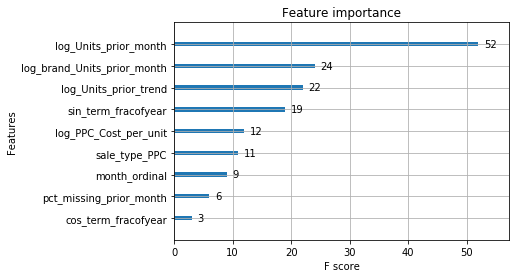

In [529]:
plot_importance(mod16,importance_type='weight')

In [530]:
#TODO: look at PPC cost per unit for transformed variable where 0 for organic units and ppc cost per unit for ppc units
#TODO: add sale type group predictor

dat_mod['log_Units'].corr(dat_mod['log_Units_prior_2_month'])

0.8660096679858127

In [531]:
np.log(2) - np.log(1)

0.6931471805599453

In [532]:
dat_sub = dat_trainvalid[dat_trainvalid['sale_type'] == 'PPC_Units']
dat_sub_perturb = dat_sub.copy()

In [533]:

explainer = shap.TreeExplainer(mod16)
shap_values = explainer.shap_values(dat_sub[features_mod16])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


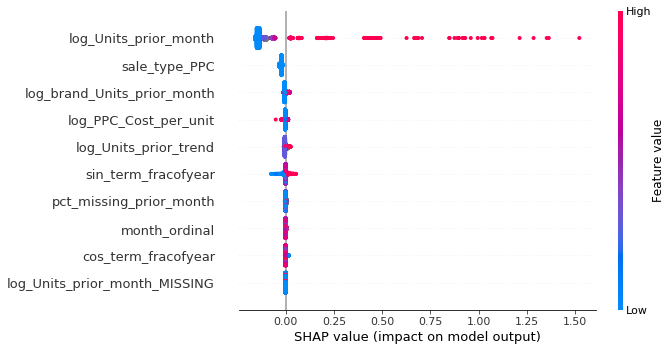

In [534]:
shap.summary_plot(shap_values, dat_sub[features_mod16])


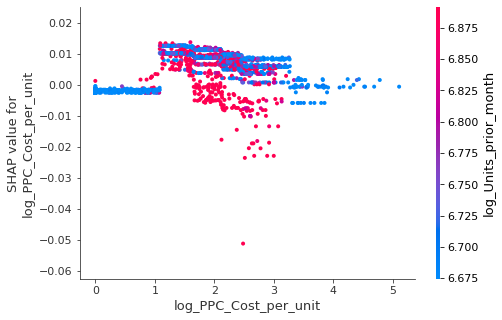

In [535]:
shap.dependence_plot('log_PPC_Cost_per_unit', shap_values, dat_sub[features_mod16],interaction_index='log_Units_prior_month')

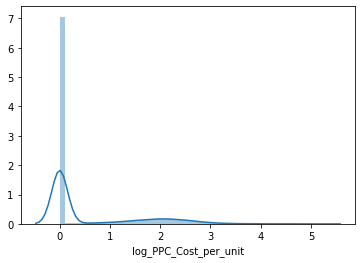

In [358]:
sns.distplot(dat_sub['log_PPC_Cost_per_unit'])

In [360]:
ppc_cost_agg = dat_sub.groupby('sku_num')['PPC_Cost_per_unit'].aggregate([np.mean, np.std,'count']).reset_index(drop=False)

In [361]:
ppc_cost_agg.fillna(0,inplace=True)

In [362]:
ppc_cost_agg = ppc_cost_agg[ppc_cost_agg['mean'] > 0]

In [363]:
dat_sub = dat_sub.merge(ppc_cost_agg[['sku_num','mean','std']],how='inner',on='sku_num')
dat_sub_perturb=dat_sub.copy()

In [440]:
pct_changes = [0.25,0.5,0.75,0.85,0.9,0.95,1,1.05,1.10,1.15,1.25,1.5,1.75]

In [441]:
agg_pred_list = {}
for pct in pct_changes:
    dat_sub_perturb['log_PPC_Cost_per_unit'] = logify(pct*dat_sub_perturb['mean'])
    dat_sub_perturb['pred'] = mod16.predict(dat_sub_perturb[features_mod16])
    dat_sub_perturb['pred_raw'] = np.exp(dat_sub_perturb['pred'])+target_min-1
    agg_pred = pd.DataFrame(dat_sub_perturb.groupby('sku_num').agg({
        'pred_raw':np.sum,
        'log_PPC_Cost_per_unit':np.mean
    }).reset_index(drop=False))
    agg_pred['pred'] = np.log(agg_pred['pred_raw'])
    agg_pred['pct_change'] = pct
    agg_pred_list[str(pct)]=agg_pred


In [442]:
agg_pred_df = pd.concat(agg_pred_list).reset_index(drop=True)

-791.0

In [443]:
coefs = {}
for s in agg_pred_df['sku_num'].unique():
    df = agg_pred_df[agg_pred_df['sku_num'] == int(s)]
    mod_lm = LinearRegression()
    mod_lm.fit(X=df[['log_PPC_Cost_per_unit']],y=df['pred'].values.ravel())
    coefs[str(s)] = [mod_lm.coef_[0]]
    

In [444]:
coef_df = pd.DataFrame.from_dict(coefs,orient='index').reset_index(drop=False)
coef_df.columns=['sku_num','coef']

In [448]:
coef_df['sku_num_obj'] = coef_df['sku_num']
coef_df['sku_num'] = coef_df['sku_num'].astype('int64')

In [575]:
coef_df

,sku_num,coef,sku_num_obj,sku_brand,Brand_ID
0,0,0.253294,0,MODLB01GR1_US-1,1
1,1,0.000000,1,MODSSBL_US-1,1
2,2,0.179226,2,MODLB01GR2_US-1,1
3,3,-0.004337,3,EO-AT4L-NSFF_US-2,2
4,4,-0.033625,4,IP-JZEN-Z9U7_US-2,2
...,...,...,...,...,...
342,468,0.000000,468,BTL-HHB-PFS-XL_US-50,50
343,470,-0.039491,470,AOR-PET-StOd2-32_US-9,9
344,471,0.000000,471,HCO-HOK-MoPe-G6_US-3,3
345,472,-0.065406,472,AOR-B07N316V8C-01_US-9,9


In [456]:
coef_df = coef_df.merge(dim_sku, how='left', on='sku_num')

In [457]:
coef_df.sort_values('coef',ascending=False)

,sku_num,coef,sku_num_obj,sku_brand,Brand_ID
99,113,2.758490,113,RV-D0XX-NB64_US-26,26
179,198,1.989999,198,pillow_prot_block_std_US-5,5
195,218,1.953800,218,U8-B5R1-I8J4_US-6,6
142,157,1.952028,157,matt_prot_max_twin_US-5,5
221,246,1.852180,246,V7-31MU-QAZH_US-6,6
...,...,...,...,...,...
4,4,-0.033625,4,IP-JZEN-Z9U7_US-2,2
343,470,-0.039491,470,AOR-PET-StOd2-32_US-9,9
345,472,-0.065406,472,AOR-B07N316V8C-01_US-9,9
254,314,-0.069251,314,KM-G3OL-GFWG_US-40,40


In [459]:
coef_df.to_csv('elast_by_sku.csv',index=False)

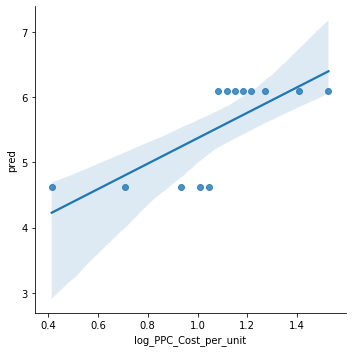

In [574]:
sns.lmplot(x='log_PPC_Cost_per_unit',y='pred',data= agg_pred_df[agg_pred_df['sku_num'] == 218])

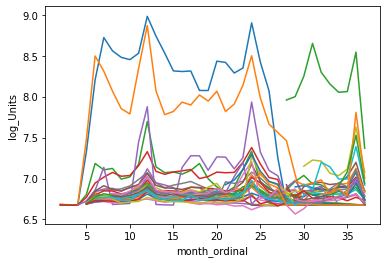

In [585]:
b = 3
dat_b = dat_mod[(dat_mod['Brand_ID']==b) & (dat_mod['sale_type'] == 'Organic_Units')]
for s in dat_b['sku_num'].unique():
    sns.lineplot(x='month_ordinal',y='log_Units',data=dat_b[dat_b['sku_num'] == s])